# Part 7a: Bitstream Generation

In the previous sections we've seen how to train a Neural Network with a small resource footprint using QKeras, then to convert it to `hls4ml` and create an IP. That IP can be interfaced into a larger design to deploy on an FPGA device. In this section, we introduce the `VivadoAccelerator` backend of `hls4ml`, where we can easily target some supported devices to get up and running quickly. Specifically, we'll deploy the model on a [pynq-z2 board](http://www.pynq.io/). NOTE: This tutorial requires on Vivado HLS instead of Vitis.

In [ ]:
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
import os

os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

## Load model
Load the model from `part4: quantization` (note you need to have trained the model in part 4 first)

In [ ]:
model = load_model('model_3/KERAS_check_best_model.h5', custom_objects=co)

## Convert to hls4ml
We'll convert our model into `hls4ml`, with a few small changes compared to the previous use of the same model in part 4.
We target  `backend='VivadoAccelerator'` backend: this will wrap the HLS NN model, providing an AXI-Stream interface to our IP. We also specify `board='pynq-z2'`.

The pynq-z2 board is a popular board with a Zynq 7020 SoC. Since this device is much smaller than the Alveo we specified in previous sections, we set the `ReuseFactor` of all the `Dense` layers of the model to 64.

In [ ]:
import hls4ml
import plotting

config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
for layer in ['fc1', 'fc2', 'fc3', 'output']:
    config['LayerName'][layer]['ReuseFactor'] = 64
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_3/hls4ml_prj_pynq', backend='VivadoAccelerator', board='pynq-z2'
)
hls_model.compile()

We can see which baords are supported in the [documentation](https://fastmachinelearning.org/hls4ml/advanced/accelerator.html). The `VivadoAccelerator` backend introduces the `AcceleratorConfig` section of configuration. Here we can change some details of the interface to the accelerator IP.


The `create_initial_config` method (of any backend) can be used to create a template dictionary with the default parameters that you can use as a starting point. In the conversion above, we didn't change any of these settings so all the defaults are used.

In [ ]:
plotting.print_dict(hls4ml.backends.get_backend('VivadoAccelerator').create_initial_config())

## Predict
Run the CPU emulation of the hls4ml NN and save the file to compare against the hardware result later.

In [ ]:
import numpy as np

X_test = np.load('X_test.npy')
y_hls = hls_model.predict(np.ascontiguousarray(X_test))
np.save('model_3/y_hls.npy', y_hls)

## Synthesize and make bitfile

Now we will synthesize the model, export the IP, and create a bitfile! The `VivadoAccelerator` backend design scripts create a Block Design in Vivado IPI containing our Neural Network IP, as well as the other necessary IPs to create a complete system.

In the case of our `pynq-z2`, we add a DMA IP to transfer data between the PS and PL containg the Neural Network. If you want to create a different design, for example to connect your NN to a sensor, you can use our block designs as a starting point and add in relevant IP for your use case.

Our block diagram looks like this:

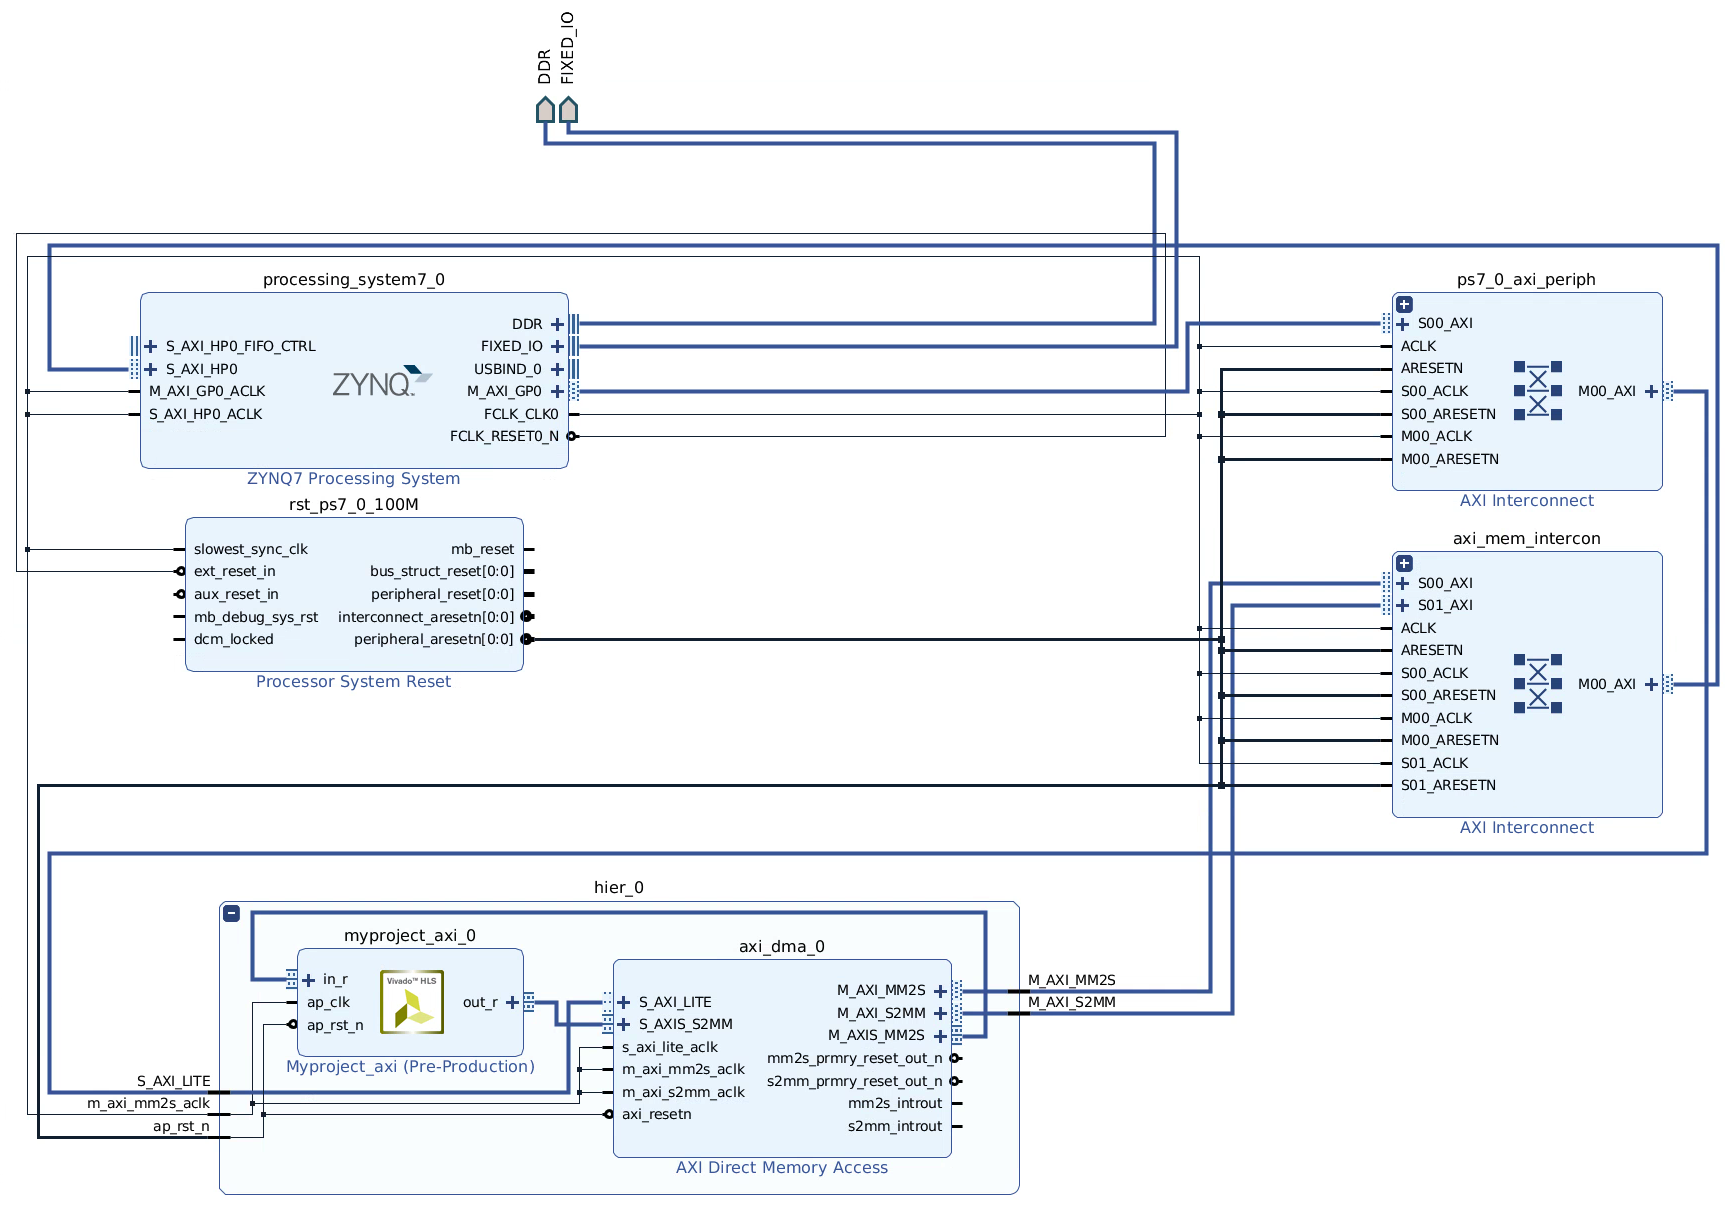

In [ ]:
hls_model.build(csim=False, export=True, bitfile=True)

The floorplan of our NN placed on the `pynq-z2` is shown below, with the hls4ml Neural Network highlighted in purple. You can reproduce this yourself if running the tutorial with a local Vivado installation by opening the project at `model_3/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.xpr` in the Vivado GUI and clicking "Open Implemented Design".

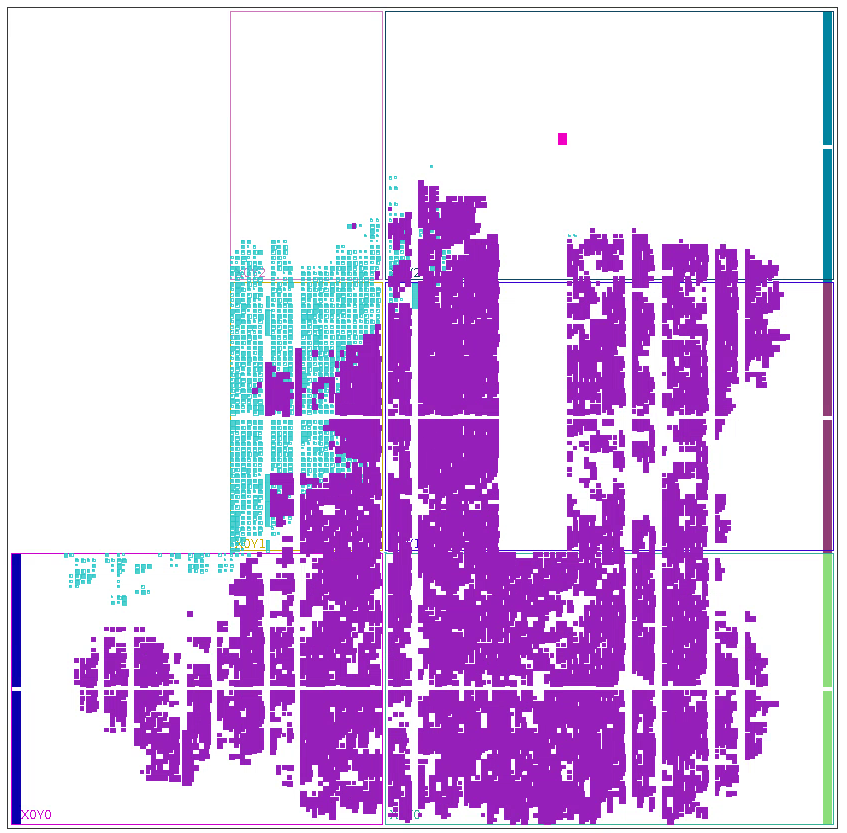

Let's also inspect the final resource usage after placement:

In [ ]:
!sed -n '30,45p' model_3/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper_utilization_placed.rpt

## Preparations for deployment
First, you'll need to follow the [setup instructions for the pynq-z2 board](https://pynq.readthedocs.io/en/latest/getting_started/pynq_z2_setup.html).
Typically, this includes connecting the board to your host via ethernet and setting up a static IP address for your host (192.168.2.1). 
The IP address for the pynq-z2 is 192.168.2.99.
The default username and password is xilinx.

Next you'll transfer the following files from the earlier part of this notebook into a directory on the pynq-z2:
- bitfile: `model_3/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper.bit` -> `hls4ml_nn.bit`
- hardware handoff: `model_3/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/hw_handoff/design_1.hwh` -> `hls4ml_nn.hwh`
- driver: `model_3/hls4ml_prj_pynq/axi_stream_driver.py` -> `axi_stream_driver.py`
- data: `X_test.npy`, `y_test.npy`
- notebook: `part7b_deployment.ipynb`

The following commands archive these files into `model_3/hls4ml_prj_pynq/package.tar.gz` that can be copied over to the pynq-z2 and extracted.

In [ ]:
!mkdir -p model_3/hls4ml_prj_pynq/package
!cp model_3/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper.bit model_3/hls4ml_prj_pynq/package/hls4ml_nn.bit
!cp model_3/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/hw_handoff/design_1.hwh model_3/hls4ml_prj_pynq/package/hls4ml_nn.hwh
!cp model_3/hls4ml_prj_pynq/axi_stream_driver.py model_3/hls4ml_prj_pynq/package/
!cp X_test.npy y_test.npy model_3/hls4ml_prj_pynq/package
!cp part7b_deployment.ipynb model_3/hls4ml_prj_pynq/package
!tar -czvf model_3/hls4ml_prj_pynq/package.tar.gz -C model_3/hls4ml_prj_pynq/package/ .

To copy it to the pynq-z2 with the default settings, the command would be:

```bash
scp model_3/hls4ml_prj_pynq/package.tar.gz xilinx@192.168.2.99:~/jupyter_notebooks
```

Then you can navigate your web browser to http://192.168.2.99.
You will see the JupyterHub running on the pynq-z2. Open a terminal and extract the tarball.

```bash
cd ~/jupyter_notebooks
tar xvzf package.tar.gz
```

Now open the notebook `part7b_deployment.ipynb` on the pynq-z2 JupyterHub